# ***Supple Chain and Demand Forecasting Using XGBOOST***  - By 221501138 and 221501135
         

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
df = pd.read_csv("/content/drive/MyDrive/Deep Learning Project/Walmart Data Analysis and Forcasting.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## **Data Preprocessing**

In [77]:
df.dtypes

,0
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


In [78]:
df.shape

(6435, 8)

In [79]:
df.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [80]:
# Adding Temporal feature for our model
df['Year'] = pd.to_datetime(df['Date'] ,format='%d-%m-%Y').dt.year
df['Month'] = pd.to_datetime(df['Date'],format='%d-%m-%Y').dt.month
df['WeekOfYear'] = pd.to_datetime(df['Date'],format='%d-%m-%Y').dt.isocalendar().week
df['DayOfWeek'] = pd.to_datetime(df['Date'],format='%d-%m-%Y').dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [81]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,0
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,4,0
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,4,0
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,4,0
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,4,0


In [82]:
# df = df.drop('Date', axis="columns")

In [83]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,0
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,4,0
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,4,0
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,4,0
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,39,4,0
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,40,4,0
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,41,4,0
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,42,4,0


In [84]:
df.Store.value_counts().head() # Which means every store has 143 data entry.

,count
Store,
1,143
24,143
26,143
27,143
28,143


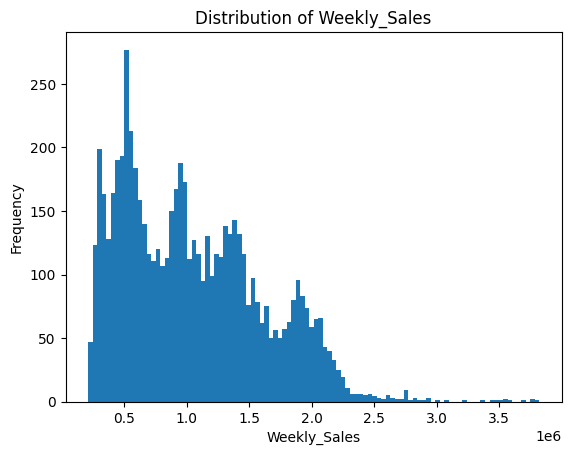

In [85]:
plt.hist(df.Weekly_Sales, bins=100)
plt.xlabel('Weekly_Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Weekly_Sales')
plt.show()

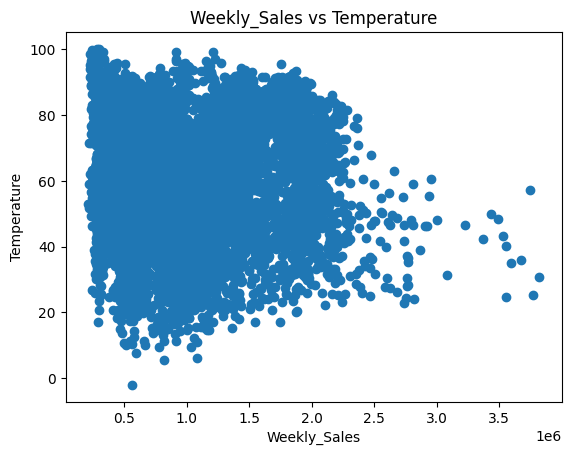

In [86]:
plt.scatter(df['Weekly_Sales'], df['Temperature'])
plt.xlabel('Weekly_Sales')
plt.ylabel('Temperature')
plt.title('Weekly_Sales vs Temperature')
plt.show()

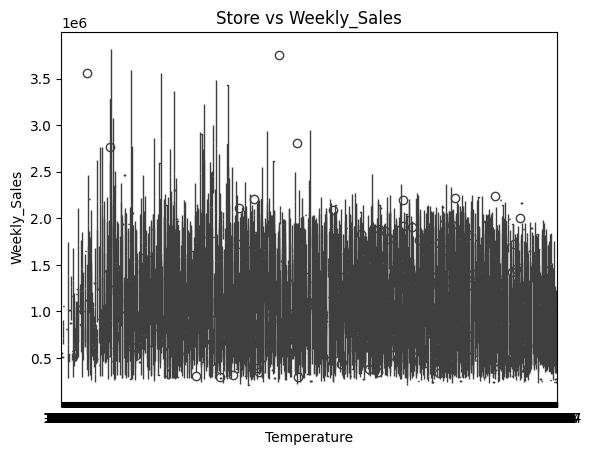

In [87]:
sns.boxplot(x='Temperature', y='Weekly_Sales', data=df)
plt.xlabel('Temperature')
plt.ylabel('Weekly_Sales')
plt.title('Store vs Weekly_Sales')
plt.show()

#**Scaling the features**

In [88]:
scaler = MinMaxScaler()

In [89]:
df[['Temperature', 'Fuel_Price', 'CPI','Unemployment']] = scaler.fit_transform(df[['Temperature','Fuel_Price','CPI','Unemployment']])

In [90]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend
0,1,05-02-2010,1643690.90,0,0.434149,0.050100,0.840500,0.405118,2010,2,5,4,0
1,1,12-02-2010,1641957.44,1,0.396967,0.038076,0.841941,0.405118,2010,2,6,4,0
2,1,19-02-2010,1611968.17,0,0.410861,0.021042,0.842405,0.405118,2010,2,7,4,0
3,1,26-02-2010,1409727.59,0,0.476419,0.044589,0.842707,0.405118,2010,2,8,4,0
4,1,05-03-2010,1554806.68,0,0.475147,0.076653,0.843008,0.405118,2010,3,9,4,0


## Extracting Lagged and Moving Average features from Target Variable

In [91]:
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')
df = df.sort_values(by=['Store', 'Date'])
df['Weekly_Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Weekly_Sales_MA_4'] = df.groupby('Store')['Weekly_Sales'].rolling(window=4).mean().reset_index(level=0, drop=True)
df.fillna(0, inplace=True)

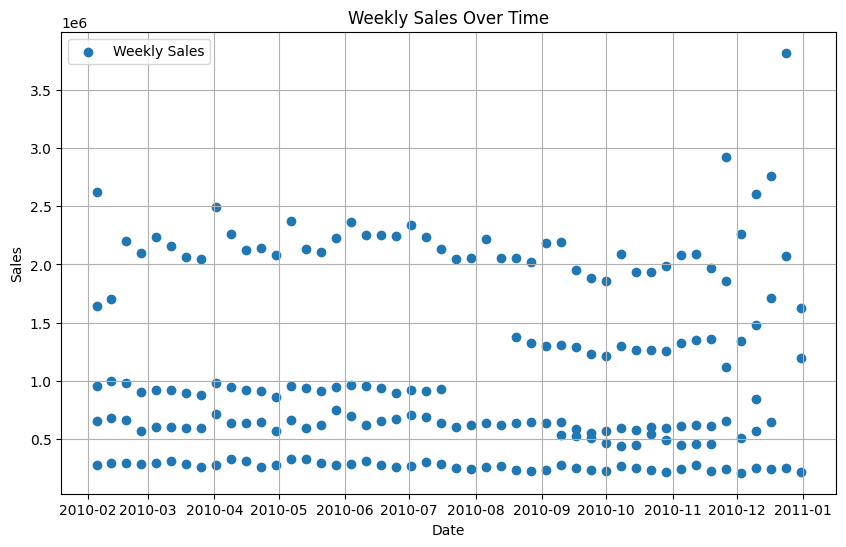

In [98]:
df_sorted = df.sort_values(by='Year', ascending=True)


df_sorted.reset_index(drop=True, inplace=True)

df_sorted = df_sorted.head(200)
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['Date'], df_sorted['Weekly_Sales'], marker='o', label='Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend,Weekly_Sales_Lag_1,Weekly_Sales_MA_4
0,1,2010-02-05,1643690.90,0,0.434149,0.050100,0.840500,0.405118,2010,2,5,4,0,0.00,0.000
1,1,2010-02-12,1641957.44,1,0.396967,0.038076,0.841941,0.405118,2010,2,6,4,0,1643690.90,0.000
2,1,2010-02-19,1611968.17,0,0.410861,0.021042,0.842405,0.405118,2010,2,7,4,0,1641957.44,0.000
3,1,2010-02-26,1409727.59,0,0.476419,0.044589,0.842707,0.405118,2010,2,8,4,0,1611968.17,1576836.025
4,1,2010-03-05,1554806.68,0,0.475147,0.076653,0.843008,0.405118,2010,3,9,4,0,1409727.59,1554614.970


In [57]:
df.corr(numeric_only = True)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend,Weekly_Sales_Lag_1,Weekly_Sales_MA_4
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531,3.474318e-12,2.910676e-15,3.106283e-15,NaN,NaN,-0.330296,-0.326639
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176,-1.837754e-02,7.614332e-02,7.421127e-02,NaN,NaN,0.934856,0.927929
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960,-5.678257e-02,1.229958e-01,1.277427e-01,NaN,NaN,0.067707,-0.010749
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158,6.426923e-02,2.358618e-01,2.361833e-01,NaN,NaN,-0.048074,-0.011909
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684,7.794703e-01,-4.215590e-02,-3.240300e-02,NaN,NaN,0.025815,0.065541
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020,7.479573e-02,4.979672e-03,6.041530e-03,NaN,NaN,-0.070074,-0.066779
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000,-2.418135e-01,-1.274559e-02,-1.589158e-02,NaN,NaN,-0.108479,-0.118810
Year,3.474318e-12,-0.018378,-5.678257e-02,0.064269,0.779470,0.074796,-0.241813,1.000000e+00,-1.944645e-01,-1.819189e-01,NaN,NaN,-0.004742,0.041778
Month,2.910676e-15,0.076143,1.229958e-01,0.235862,-0.042156,0.004980,-0.012746,-1.944645e-01,1.000000e+00,9.959843e-01,NaN,NaN,0.097858,0.095356
WeekOfYear,3.106283e-15,0.074211,1.277427e-01,0.236183,-0.032403,0.006042,-0.015892,-1.819189e-01,9.959843e-01,1.000000e+00,NaN,NaN,0.100841,0.096959


[]

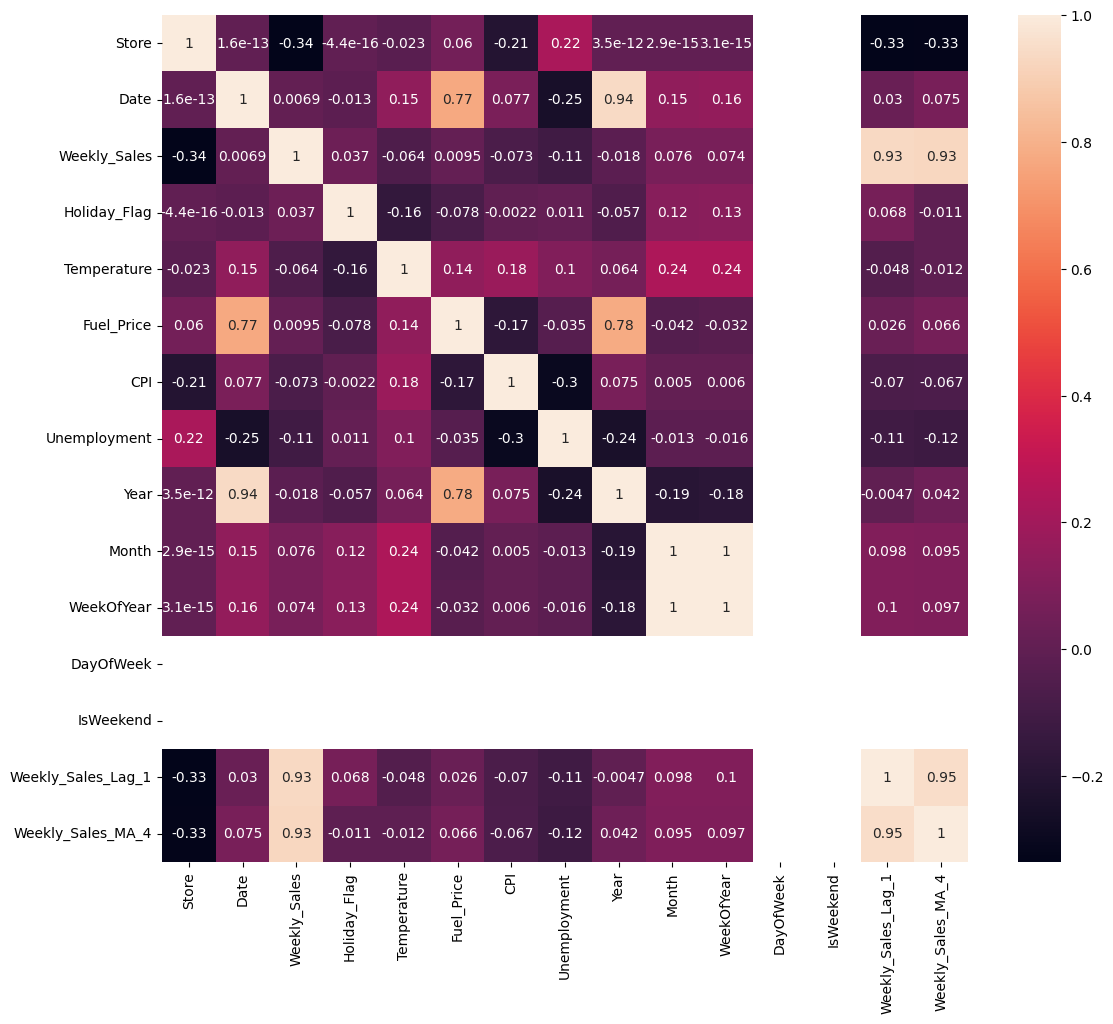

In [58]:
plt.figure(figsize=(13, 11))
sns.heatmap(df.corr(), annot=True)
plt.plot()

## Spliting the Dataset

In [59]:
df1 = df.copy()
X = df1.drop(['Store','Weekly_Sales','Date'], axis=1)
Y = df['Weekly_Sales']

In [60]:
X.columns

Index(['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'IsWeekend',
       'Weekly_Sales_Lag_1', 'Weekly_Sales_MA_4'],
      dtype='object')

In [61]:
Y.head()

,Weekly_Sales
0,1643690.90
1,1641957.44
2,1611968.17
3,1409727.59
4,1554806.68


In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# XGBOOST

In [63]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 2,                   # Depth of each tree
    'eta': 0.1,                       # Learning rate
    'subsample': 0.99,                 # Subsample ratio for training
    'colsample_bytree': 0.99,          # Subsample ratio for features
    'seed': 42                        # Seed for reproducibility
}


xg_reg = xgb.train(params, dtrain, num_boost_round=100)

In [64]:
evallist = [(dtrain, 'train'), (dtest, 'test')]

# Train the model
xg_reg = xgb.train(params, dtrain, num_boost_round=100, evals=evallist, verbose_eval=10)


[0]	train-rmse:515118.82952	test-rmse:517963.38175
[10]	train-rmse:249611.86715	test-rmse:245635.10085
[20]	train-rmse:176643.85311	test-rmse:168587.81429
[30]	train-rmse:150739.14492	test-rmse:142849.71551
[40]	train-rmse:136006.17946	test-rmse:127272.91641
[50]	train-rmse:126190.76594	test-rmse:117535.54322
[60]	train-rmse:118518.07875	test-rmse:110402.70991
[70]	train-rmse:113807.47547	test-rmse:105185.28116
[80]	train-rmse:109663.91366	test-rmse:101534.99152
[90]	train-rmse:106326.23736	test-rmse:98256.16600
[99]	train-rmse:102547.71019	test-rmse:94783.57405


In [65]:
# Predict
y_train_pred = xg_reg.predict(dtrain)
y_test_pred = xg_reg.predict(dtest)


In [66]:
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# R^2 Scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training R^2 Score:", train_r2)
print("Testing R^2 Score:", test_r2)


Training RMSE: 102547.7103297057
Testing RMSE: 94783.57155291887
Training R^2 Score: 0.9668804327457713
Testing R^2 Score: 0.9721129966091234


In [67]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,DayOfWeek,IsWeekend,Weekly_Sales_Lag_1,Weekly_Sales_MA_4
0,1,2010-02-05,1643690.90,0,0.434149,0.050100,0.840500,0.405118,2010,2,5,4,0,0.00,0.000
1,1,2010-02-12,1641957.44,1,0.396967,0.038076,0.841941,0.405118,2010,2,6,4,0,1643690.90,0.000
2,1,2010-02-19,1611968.17,0,0.410861,0.021042,0.842405,0.405118,2010,2,7,4,0,1641957.44,0.000
3,1,2010-02-26,1409727.59,0,0.476419,0.044589,0.842707,0.405118,2010,2,8,4,0,1611968.17,1576836.025
4,1,2010-03-05,1554806.68,0,0.475147,0.076653,0.843008,0.405118,2010,3,9,4,0,1409727.59,1554614.970


In [68]:
# New input
new_data = {
    'Holiday_Flag': [1],  # Indicates it's a holiday week
    'Temperature': [35.0],  # Weather might impact sales
    'Fuel_Price': [3.2],  # Higher fuel price could decrease sales
    'CPI': [250.0],  # Higher CPI, possibly lower sales
    'Unemployment': [5.0],  # Unemployment might increase demand for discount sales
    'Year': [2024],
    'Month': [12],
    'WeekOfYear': [50],  # Around Christmas time, typically higher sales
    'DayOfWeek': [5],  # Friday
    'IsWeekend': [1],  # It's a weekend
    'Weekly_Sales_Lag_1': [1500000],  # Previous sales are much higher
    'Weekly_Sales_MA_4': [1200000]  # Averages from the previous four weeks
}

# Convert to DataFrame
new_data_df = pd.DataFrame(new_data)

# Scale required columns
new_data_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']] = scaler.transform(
    new_data_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
)

# Convert to DMatrix for prediction
dmatrix_new = xgb.DMatrix(new_data_df)

# Predict
predicted_sales = xg_reg.predict(dmatrix_new)
print("Predicted Weekly Sales for Next Week:", predicted_sales[0])


Predicted Weekly Sales for Next Week: 1355442.4


In [69]:
import pickle
import xgboost as xgb

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xg_reg, f)

In [70]:
print("x_train Columns:", x_train.columns.tolist())
print("new_data_df Columns:", new_data_df.columns.tolist())


x_train Columns: ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'IsWeekend', 'Weekly_Sales_Lag_1', 'Weekly_Sales_MA_4']
new_data_df Columns: ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'IsWeekend', 'Weekly_Sales_Lag_1', 'Weekly_Sales_MA_4']


In [71]:
print("DMatrix Feature Names:", dmatrix_new.feature_names)


DMatrix Feature Names: ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'IsWeekend', 'Weekly_Sales_Lag_1', 'Weekly_Sales_MA_4']


In [72]:
print("Scaler Min-Max Ranges:", scaler.data_min_, scaler.data_max_)
print("New Data Scaled Values:", new_data_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])


Scaler Min-Max Ranges: [ -2.06    2.472 126.064   3.879] [100.14        4.468     227.2328068  14.313    ]
New Data Scaled Values:    Temperature  Fuel_Price       CPI  Unemployment
0     0.362622    0.364729  1.225042      0.107437


In [73]:
dmatrix_train_sample = xgb.DMatrix(x_train.iloc[[0]])  # First row of training data
train_sample_prediction = xg_reg.predict(dmatrix_train_sample)
print("Prediction on Training Sample:", train_sample_prediction[0])

Prediction on Training Sample: 862684.25
